<a href="https://colab.research.google.com/github/Rifki243/Membangun-Proyek-Machine-Learning/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Muhamad_Rifki_Ardi_Priadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [48]:
# Membuat variabel untuk memilih file
uploaded = files.upload()

Saving Dataset_clustering.csv to Dataset_clustering.csv


In [50]:
df = pd.read_csv('Dataset_Clustering.csv')
df.head()

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date,Cluster,Order_Month
0,ORD1663596,CUS5073,B2B,Hohes C Orange,Juices,21.788633,137.496565,0.033756,2691.343429,Niedersachsen,2023-11-29,3,2023-11
1,ORD1999010,CUS141,B2B,Fritz-Kola,Soft Drinks,21.788633,101.016747,0.031676,1984.355357,Bremen,2021-05-13,8,2021-05
2,ORD347756,CUS562,B2B,Merlot,Alcoholic Beverages,44.634094,136.411987,0.035743,3620.688886,Thüringen,2021-04-21,3,2021-04
3,ORD600360,CUS7718,B2B,Moët & Chandon,Alcoholic Beverages,69.087783,142.924517,0.033756,4672.623551,Hamburg,2021-08-23,2,2021-08
4,ORD2300591,CUS6160,B2C,Granini Apple,Juices,20.527920,65.547807,0.029495,1205.274995,Sachsen,2022-10-16,1,2022-10


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order_ID       10000 non-null  object 
 1   Customer_ID    10000 non-null  object 
 2   Customer_Type  10000 non-null  object 
 3   Product        10000 non-null  object 
 4   Category       10000 non-null  object 
 5   Unit_Price     10000 non-null  float64
 6   Quantity       10000 non-null  float64
 7   Discount       10000 non-null  float64
 8   Total_Price    10000 non-null  float64
 9   Region         10000 non-null  object 
 10  Order_Date     10000 non-null  object 
 11  Cluster        10000 non-null  int64  
 12  Order_Month    10000 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 1015.8+ KB


In [52]:
# Merubah tipe data
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_Month'] = df['Order_Date'].dt.to_period('M')

In [53]:
categorical_columns = []
numerical_columns = []
datetime_columns = []
period_columns = []

for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)
    elif df[column].dtype == 'datetime64[ns]':
        datetime_columns.append(column)
    elif df[column].dtype == 'period[M]':
        period_columns.append(column)
    else:
        numerical_columns.append(column)
print("Kolom kategorikal:", categorical_columns)
print("Kolom numerikal:", numerical_columns)
print("Kolom datetime:", datetime_columns)
print("Kolom period:", period_columns)
print(f"\nJumlah kolom kategorikal: {len(categorical_columns)}, kolom numerikal: {len(numerical_columns)}, kolom datetime: {len(datetime_columns)}, kolom period: {len(period_columns)}")
print("\nTotal kolom:", len(categorical_columns) + len(numerical_columns) + len(datetime_columns) + len(period_columns))

Kolom kategorikal: ['Order_ID', 'Customer_ID', 'Customer_Type', 'Product', 'Category', 'Region']
Kolom numerikal: ['Unit_Price', 'Quantity', 'Discount', 'Total_Price', 'Cluster']
Kolom datetime: ['Order_Date']
Kolom period: ['Order_Month']

Jumlah kolom kategorikal: 6, kolom numerikal: 5, kolom datetime: 1, kolom period: 1

Total kolom: 13


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [54]:
# Memisahkan fitur (X) dan target (y)
X = df.drop('Cluster', axis=1)
y = df['Cluster']

In [55]:
# Hapus kolom ID dan waktu
X = X.drop(['Order_ID', 'Customer_ID', 'Order_Date', 'Order_Month'], axis=1)

In [56]:
# Normalisasi fitur numerik
numerical_features = X.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X[numerical_features].head()

,Unit_Price,Quantity,Discount,Total_Price
0,-0.227755,1.624645,1.586424,0.993247
1,-0.227755,0.311637,0.487435,0.118433
2,1.514042,1.585608,2.636552,2.143203
3,3.378455,1.820012,1.586424,3.444848
4,-0.323875,-0.964986,-0.665183,-0.845587


In [57]:
# Pilih hanya kolom kategorikal
categorical_features = X.select_dtypes(include=['object']).columns

# Buat LabelEncoder untuk setiap kolom yang dipilih
label_encoders = {}

for column in categorical_features:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le  # Simpan encoder jika nanti perlu inverse_transform

# Tampilkan hasil encoding hanya untuk kolom kategorikal yang dipilih
X.head()

,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,0,15,1,-0.227755,1.624645,1.586424,0.993247,8
1,0,11,2,-0.227755,0.311637,0.487435,0.118433,4
2,0,22,0,1.514042,1.585608,2.636552,2.143203,15
3,0,26,0,3.378455,1.820012,1.586424,3.444848,5
4,1,13,1,-0.323875,-0.964986,-0.665183,-0.845587,12


In [58]:
print("Cek tipe data sebelum split:")
print(X.dtypes)

Cek tipe data sebelum split:
Customer_Type      int64
Product            int64
Category           int64
Unit_Price       float64
Quantity         float64
Discount         float64
Total_Price      float64
Region             int64
dtype: object


In [59]:
# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [60]:
# Menghitung panjang/jumlah data
print("Jumlah data: ",len(X))
# Menghitung panjang/jumlah data pada x_test
print("Jumlah data latih: ",len(X_train))
# Menghitung panjang/jumlah data pada x_test
print("Jumlah data test: ",len(X_test))

Jumlah data:  10000
Jumlah data latih:  8000
Jumlah data test:  2000


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [61]:
# Melatih Model 1 dengan algoritma K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Melatih Model 2 dengan algoritma Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Melatih Model 3 dengan algoritma Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [62]:
print(X_train.dtypes)

Customer_Type      int64
Product            int64
Category           int64
Unit_Price       float64
Quantity         float64
Discount         float64
Total_Price      float64
Region             int64
dtype: object


### **1. K-Nearest Neighbors (KNN)**
Algoritma K-Nearest Neighbors (KNN) adalah algoritma yang bekerja dengan mengklasifikasikan sampel berdasarkan kedekatan dengan titik data lain di sekitarnya. Model ini mudah dipahami dan sangat efektif untuk dataset kecil hingga menengah, terutama ketika pola dalam data dapat dikenali secara lokal. Namun, KNN memiliki kelemahan dalam hal efisiensi pada dataset besar karena harus menghitung jarak ke semua titik data saat melakukan prediksi.

### **2. Random Forest**
Algoritma Random Forest (RF) adalah metode ensemble yang menggabungkan banyak Decision Tree untuk meningkatkan akurasi dan stabilitas model. Dengan membangun beberapa pohon keputusan secara acak dan menggabungkan hasilnya, RF mampu menangani dataset dengan banyak fitur serta mengurangi risiko overfitting dibandingkan Decision Tree tunggal. Selain itu, model ini juga sangat baik dalam menangani data yang kompleks dan dapat memberikan informasi penting mengenai fitur yang paling berpengaruh dalam klasifikasi.

### **3. Decision Tree**
Algoritma Decision Tree (DT) adalah model yang mudah diinterpretasikan karena strukturnya menyerupai aturan keputusan yang dapat dipahami dengan jelas. Algoritma ini sangat baik dalam menangkap hubungan non-linear dalam data, sehingga cocok untuk berbagai jenis masalah klasifikasi. Namun, jika tidak dikontrol dengan baik, Decision Tree dapat mengalami overfitting, sehingga perlu dilakukan pruning atau pengaturan kedalaman pohon yang optimal agar model tetap memiliki kemampuan generalisasi yang baik.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

Evaluasi Model: K-Nearest Neighbors
Accuracy: 0.8725
F1-Score: 0.8668
Precision: 0.8735
Recall: 0.8725

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.71      0.62       124
           1       0.97      1.00      0.98      1223
           2       0.41      0.60      0.49        15
           3       0.71      0.82      0.76       187
           4       0.80      0.80      0.80         5
           5       0.93      0.98      0.96        87
           6       0.91      0.95      0.93        22
           7       0.62      0.45      0.52       113
           8       0.83      0.51      0.63       190
           9       0.68      0.44      0.54        34

    accuracy                           0.87      2000
   macro avg       0.74      0.73      0.72      2000
weighted avg       0.87      0.87      0.87      2000



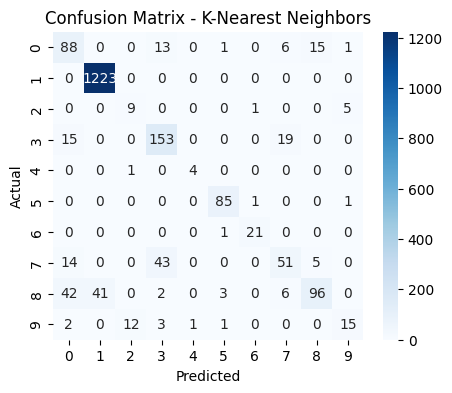



Evaluasi Model: Random Forest
Accuracy: 0.9950
F1-Score: 0.9949
Precision: 0.9952
Recall: 0.9950

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      1.00      1.00      1223
           2       0.88      0.93      0.90        15
           3       1.00      0.98      0.99       187
           4       1.00      0.60      0.75         5
           5       1.00      0.98      0.99        87
           6       1.00      1.00      1.00        22
           7       0.97      1.00      0.99       113
           8       1.00      0.99      1.00       190
           9       0.92      1.00      0.96        34

    accuracy                           0.99      2000
   macro avg       0.98      0.95      0.96      2000
weighted avg       1.00      0.99      0.99      2000



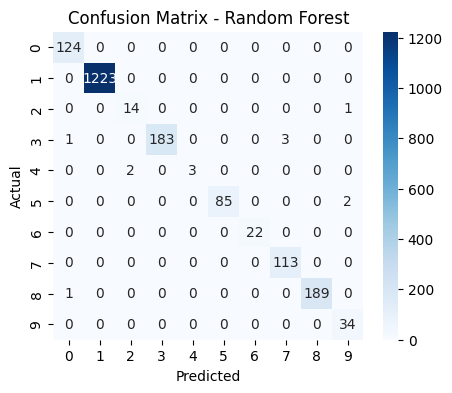



Evaluasi Model: Decision Tree
Accuracy: 0.9950
F1-Score: 0.9950
Precision: 0.9952
Recall: 0.9950

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      1.00      1.00      1223
           2       0.86      0.80      0.83        15
           3       1.00      1.00      1.00       187
           4       1.00      0.80      0.89         5
           5       1.00      0.98      0.99        87
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00       113
           8       1.00      0.99      0.99       190
           9       0.86      0.94      0.90        34

    accuracy                           0.99      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       1.00      0.99      1.00      2000



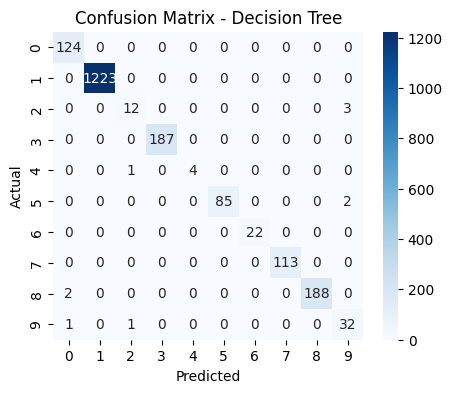

In [63]:
# List model yang akan dievaluasi
models = {
    "K-Nearest Neighbors": knn,
    "Random Forest": rf,
    "Decision Tree": dt
}

# Lakukan prediksi pada data uji dan evaluasi setiap model
for name, model in models.items():
    y_pred = model.predict(X_test)

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Print hasil evaluasi
    print(f"Evaluasi Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Buat Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    print("\n")

### **Evaluasi Model K-Nearest Neighbors (KNN)**
Model KNN memperoleh akurasi sebesar 87.25% dengan F1-score 86.68%. Precision dan Recall juga cukup baik, masing-masing 87.35% dan 87.25%.

Namun, jika melihat classification report, performa model berbeda-beda di setiap kelas. Kelas dengan jumlah sampel yang besar seperti kelas 1 dan 3 memiliki skor precision dan recall yang tinggi, tetapi pada kelas dengan jumlah sampel kecil seperti kelas 2, 4, dan 9, performa model lebih rendah. Hal ini wajar karena KNN bekerja dengan mencari tetangga terdekat, sehingga rentan terhadap distribusi data yang tidak merata.

### **Evaluasi Model Random Forest**
Model Random Forest menunjukkan hasil terbaik dengan akurasi 99.50% dan F1-score 99.49%. Precision dan recall juga sangat tinggi, masing-masing 99.52% dan 99.50%.

Dari classification report, terlihat bahwa hampir semua kelas memiliki precision dan recall di atas 90%, bahkan beberapa kelas mencapai 100% akurasi. Model ini bekerja dengan baik karena mampu menangani data yang kompleks, mengurangi overfitting, dan menangkap pola dari data dengan lebih baik dibandingkan KNN.

### **Evaluasi Model Decision Tree**
Model Decision Tree juga memiliki akurasi 99.50%, sama seperti Random Forest, dengan F1-score 99.50%. Precision dan recall juga sangat tinggi, yaitu 99.52% dan 99.50%.

Dari classification report, terlihat bahwa sebagian besar kelas memiliki skor mendekati 100%, dengan pengecualian pada beberapa kelas kecil seperti kelas 2 dan 4, yang memiliki skor sedikit lebih rendah. Model ini cenderung overfitting terhadap data, karena Decision Tree mudah belajar pola secara spesifik dari dataset pelatihan.

### **Kesimpulan dan Perbandingan**
1. K-Nearest Neighbors (KNN) memiliki performa yang cukup baik, tetapi lebih rentan terhadap ketidakseimbangan data dan memiliki skor yang lebih rendah dibandingkan RF dan DT.
2. Random Forest (RF) adalah model terbaik dalam eksperimen ini, karena memiliki akurasi tinggi, F1-score tinggi, dan mampu menangani data dengan lebih baik.
3. Decision Tree (DT) juga memiliki akurasi yang sangat tinggi, tetapi cenderung overfitting, yang membuatnya kurang fleksibel dibandingkan Random Forest.

Secara keseluruhan, **Random Forest** adalah pilihan terbaik karena memberikan performa konsisten tinggi tanpa terlalu overfitting seperti Decision Tree.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

### **Hyperparameter Tuning untuk Model K-Nearest Neighbors (KNN)**

In [64]:
# Definisi parameter grid untuk KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Jumlah tetangga
    'weights': ['uniform', 'distance'],  # Metode pemberian bobot
    'metric': ['euclidean', 'manhattan']  # Jenis metrik jarak
}

# Grid Search untuk KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Model KNN terbaik
best_knn = grid_search_knn.best_estimator_
best_params_knn = grid_search_knn.best_params_

# Prediksi dengan model terbaik
y_train_pred_knn = best_knn.predict(X_train)
y_test_pred_knn = best_knn.predict(X_test)

# Evaluasi akurasi
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

print(f"KNN - Training Accuracy: {train_acc_knn}")
print(f"KNN - Test Accuracy: {test_acc_knn}")
print(f"KNN - Best Params: {best_params_knn}")

KNN - Training Accuracy: 1.0
KNN - Test Accuracy: 0.9125
KNN - Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


### **Hyperparameter Tuning untuk Model Random Forest (RF)**

In [65]:
# Definisi parameter grid untuk Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Jumlah pohon dalam forest
    'max_depth': [None, 10, 20],  # Kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],  # Jumlah minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di leaf node
    'bootstrap': [True, False]  # Teknik sampling data
}

# Grid Search untuk Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Model RF terbaik
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

# Prediksi dengan model terbaik
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

# Evaluasi akurasi
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"RF - Training Accuracy: {train_acc_rf}")
print(f"RF - Test Accuracy: {test_acc_rf}")
print(f"RF - Best Params: {best_params_rf}")

RF - Training Accuracy: 1.0
RF - Test Accuracy: 0.9955
RF - Best Params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


### **Hyperparameter Tuning untuk Model Decision Tree (DT)**

In [66]:
# Definisi parameter grid untuk Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 15],  # Kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4]  # Minimum sampel di setiap daun
}

# Grid Search untuk Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Model Decision Tree terbaik
best_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_

# Prediksi dengan model terbaik
y_train_pred_dt = best_dt.predict(X_train)
y_test_pred_dt = best_dt.predict(X_test)

# Evaluasi akurasi
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)

print(f"DT - Training Accuracy: {train_acc_dt}")
print(f"DT - Test Accuracy: {test_acc_dt}")
print(f"DT - Best Params: {best_params_dt}")

DT - Training Accuracy: 1.0
DT - Test Accuracy: 0.995
DT - Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

Evaluasi Model Setelah Tuning: K-Nearest Neighbors
Accuracy: 0.9125
F1-Score: 0.9106
Precision: 0.9120
Recall: 0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       124
           1       0.99      1.00      0.99      1223
           2       0.57      0.80      0.67        15
           3       0.76      0.89      0.82       187
           4       1.00      0.80      0.89         5
           5       0.96      0.94      0.95        87
           6       0.88      0.95      0.91        22
           7       0.71      0.59      0.65       113
           8       0.86      0.75      0.80       190
           9       0.75      0.53      0.62        34

    accuracy                           0.91      2000
   macro avg       0.82      0.80      0.80      2000
weighted avg       0.91      0.91      0.91      2000



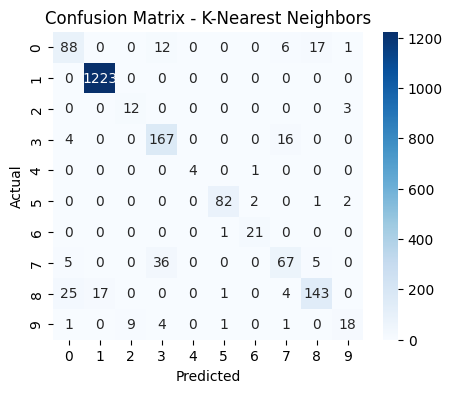



Evaluasi Model Setelah Tuning: Random Forest
Accuracy: 0.9955
F1-Score: 0.9954
Precision: 0.9957
Recall: 0.9955

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       124
           1       1.00      1.00      1.00      1223
           2       0.88      0.93      0.90        15
           3       1.00      0.98      0.99       187
           4       1.00      0.60      0.75         5
           5       1.00      0.98      0.99        87
           6       1.00      1.00      1.00        22
           7       0.97      1.00      0.99       113
           8       1.00      0.99      1.00       190
           9       0.92      1.00      0.96        34

    accuracy                           1.00      2000
   macro avg       0.98      0.95      0.96      2000
weighted avg       1.00      1.00      1.00      2000



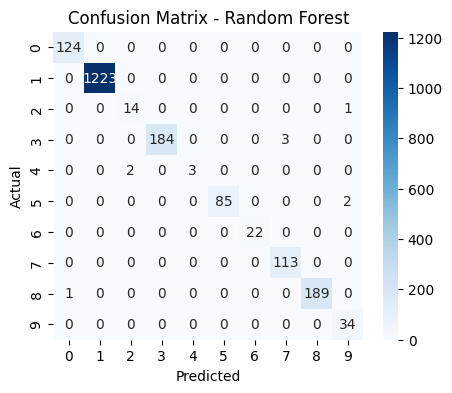



Evaluasi Model Setelah Tuning: Decision Tree
Accuracy: 0.9950
F1-Score: 0.9950
Precision: 0.9952
Recall: 0.9950

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      1.00      1.00      1223
           2       0.86      0.80      0.83        15
           3       1.00      1.00      1.00       187
           4       1.00      0.80      0.89         5
           5       1.00      0.98      0.99        87
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00       113
           8       1.00      0.99      0.99       190
           9       0.86      0.94      0.90        34

    accuracy                           0.99      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       1.00      0.99      1.00      2000



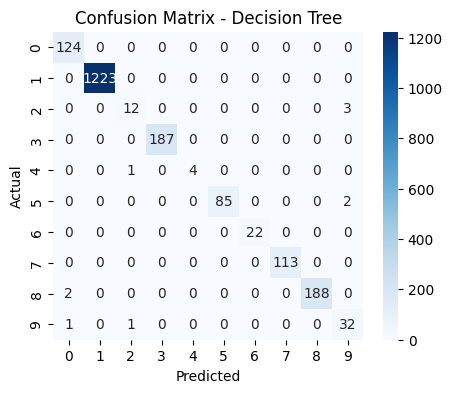

In [67]:
# Model terbaik dari tuning
tuned_models = {
    "K-Nearest Neighbors": best_knn,
    "Random Forest": best_rf,
    "Decision Tree": best_dt
}

# Evaluasi setiap model setelah tuning
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Print hasil evaluasi
    print(f"Evaluasi Model Setelah Tuning: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Buat Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    print("\n")

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

### Kesimpulan
**1. Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning**
- K-Nearest Neighbors (KNN) Meningkat Signifikan
 - Accuracy naik dari 87.25% -> 91.25% setelah tuning.
 - F1-Score naik dari 86.68% -> 91.06% menunjukkan model lebih seimbang.
 - Precision & Recall meningkat, artinya model lebih baik dalam mengenali kelas-kelas yang ada.
 - Kesimpulan: Tuning pada KNN berhasil meningkatkan performa secara signifikan.

- Random Forest Hanya Sedikit Meningkat
 - Accuracy naik dari 99.50% -> 99.55% (hanya +0.05%).
 - F1-Score, Precision, dan Recall juga meningkat sedikit.
 - Kesimpulan: Model sudah sangat baik sejak awal, tuning hanya memberikan sedikit peningkatan.

- Decision Tree Tidak Berubah
 - Tidak ada peningkatan dalam metrik evaluasi.
 - Kemungkinan besar model sudah mencapai performa maksimal sebelum tuning.
 - Kesimpulan: Tuning tidak memberikan dampak signifikan pada Decision Tree.

**2. Apakah Model Mengalami Overfitting dan Underfitting**
- Random Forest & Decision Tree menunjukkan accuracy sangat tinggi (99.5%), kemungkinan ada overfitting.

 - Solusi:
    - Coba kurangi kompleksitas model (misal: kurangi max_depth atau n_estimators pada RF).
    - Gunakan lebih banyak data uji untuk validasi lebih lanjut.

- KNN meningkat tanpa overfitting menandakan tuning efektif tanpa kehilangan generalisasi.

**3. Rekomendasi Tindakan Lanjutan**
- Algoritma yang saya gunakan yaitu K-Nearest Neighbors, Random Forest, Decision Tree, saya melihat dari ketiga algoritma yang saya pakai ada baik dan kurangnya, jika ingin mengandalkan akurasi tertinggi silahkan menggunakan Random Forest, namun jika ingin model yang lebih ringan dan efisien bisa menggunakan K-Nearest Neighbors.
- Jika dilihat dari hasil, mungkin saya akan mengurangi kompleksitas model, misalnya dengan menyesuaikan parameter `max_depth` dan `n_estimators` pada Random Forest dan juga mungkin saya akan menerapkan teknik pruning pada Decision Tree agar model tidak terlalu kompleks.
- Langkah selanjutnya mungkin saya akan menyesuaikan parameter lebih lanjut atau mengeksplorasi model lain seperti XGBoost dan SVM.